In [1]:
# imports and basic notebook setup
from cStringIO import StringIO
import numpy as np
import scipy.ndimage as nd
import PIL.Image
from IPython.display import clear_output, Image, display
from google.protobuf import text_format

import datetime
import caffe
import os

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [2]:
model_path = '../caffe/models/bvlc_googlenet/' # substitute your path here
net_fn   = model_path + 'deploy.prototxt'
param_fn = model_path + 'bvlc_googlenet.caffemodel'

# Patching model to be able to compute gradients.
# Note that you can also manually add "force_backward: true" line to "deploy.prototxt".
model = caffe.io.caffe_pb2.NetParameter()
text_format.Merge(open(net_fn).read(), model)
model.force_backward = True
open('tmp.prototxt', 'w').write(str(model))

net = caffe.Classifier('tmp.prototxt', param_fn,
                       mean = np.float32([104.0, 116.0, 122.0]), # ImageNet mean, training set dependent
                       channel_swap = (2,1,0)) # the reference model has channels in BGR order instead of RGB

# a couple of utility functions for converting to and from Caffe's input image layout
def preprocess(net, img):
    return np.float32(np.rollaxis(img, 2)[::-1]) - net.transformer.mean['data']
def deprocess(net, img):
    return np.dstack((img + net.transformer.mean['data'])[::-1])

In [3]:
def make_step(net, step_size=1.5, end='inception_3b/5x5_reduce', jitter=35, clip=True):
    '''Basic gradient ascent step.'''

    src = net.blobs['data'] # input image is stored in Net's 'data' blob
    dst = net.blobs[end]

    ox, oy = np.random.randint(-jitter, jitter+1, 2)
    src.data[0] = np.roll(np.roll(src.data[0], ox, -1), oy, -2) # apply jitter shift
            
    net.forward(end=end)
    dst.diff[:] = dst.data  # specify the optimization objective
    net.backward(start=end)
    g = src.diff[0]
    # apply normalized ascent step to the input image
    src.data[:] += step_size/np.abs(g).mean() * g

    src.data[0] = np.roll(np.roll(src.data[0], -ox, -1), -oy, -2) # unshift image
            
    if clip:
        bias = net.transformer.mean['data']
        src.data[:] = np.clip(src.data, -bias, 255-bias)    

In [4]:
def deepdream(net,base_img, iter_n=10, octave_n=4, octave_scale=1.4, end='inception_4c/3x3_reduce', clip=True, **step_params):
    # prepare base images for all octaves
    octaves = [preprocess(net, base_img)]
    
   
    for i in xrange(octave_n-1):
        octaves.append(nd.zoom(octaves[-1], (1, 1.0/octave_scale,1.0/octave_scale), order=1))
    
    src = net.blobs['data']
    detail = np.zeros_like(octaves[-1]) # allocate image for network-produced details
    for octave, octave_base in enumerate(octaves[::-1]):
        h, w = octave_base.shape[-2:]
        if octave > 0:
            # upscale details from the previous octave
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1.0*h/h1,1.0*w/w1), order=1)

        src.reshape(1,3,h,w) # resize the network's input image size
        src.data[0] = octave_base+detail
        for i in xrange(iter_n):
            make_step(net, end=end, clip=clip, **step_params)
            
            # visualization
            vis = deprocess(net, src.data[0])
            if not clip: # adjust image contrast if clipping is disabled
                vis = vis*(255.0/np.percentile(vis, 99.98))
            showarray(vis)
            print octave, i, end, vis.shape
            clear_output(wait=True)
            
        # extract details produced on the current octave
        detail = src.data[0]-octave_base
    # returning the resulting image
    return deprocess(net, src.data[0])

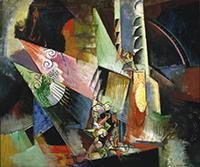

In [5]:
img = np.float32(PIL.Image.open('images/max.jpg'))
#img2 = np.float32(PIL.Image.open('jglyph.jpg'))
#img3 = np.float32(PIL.Image.open('nasa.jpg'))
showarray(img)
#showarray(img2)
#showarray(img3)

In [16]:
layer_list = ["conv1/7x7_s2",
"pool1/3x3_s2",
"pool1/norm1",
"conv2/3x3_reduce",
"conv2/3x3",
"conv2/norm2",
"pool2/3x3_s2",
"inception_3a/1x1",
"inception_3a/3x3_reduce",
"inception_3a/3x3",
"inception_3a/5x5_reduce",
"inception_3a/5x5",
"inception_3a/pool",
"inception_3a/pool_proj",
"inception_3a/output",
"inception_3b/1x1",
"inception_3b/3x3_reduce",
"inception_3b/3x3",
"inception_3b/5x5_reduce",
"inception_3b/5x5",
"inception_3b/pool",
"inception_3b/pool_proj",
"inception_3b/output",
"pool3/3x3_s2",
"inception_4a/1x1",
"inception_4a/3x3_reduce",
"inception_4a/3x3",
"inception_4a/5x5_reduce",
"inception_4a/5x5",
"inception_4a/pool",
"inception_4a/pool_proj",
"inception_4a/output",
"inception_4b/1x1",
"inception_4b/3x3_reduce",
"inception_4b/3x3",
"inception_4b/5x5_reduce",
"inception_4b/5x5",
"inception_4b/pool",
"inception_4b/pool_proj",
"inception_4b/output",
"inception_4c/1x1",
"inception_4c/3x3_reduce",
"inception_4c/3x3",
"inception_4c/5x5_reduce",
"inception_4c/5x5",
"inception_4c/pool",
"inception_4c/pool_proj",
"inception_4c/output",
"inception_4d/1x1",
"inception_4d/3x3_reduce",
"inception_4d/3x3",
"inception_4d/5x5_reduce",
"inception_4d/5x5",
"inception_4d/pool",
"inception_4d/pool_proj",
"inception_4d/output",
"inception_4e/1x1",
"inception_4e/3x3_reduce",
"inception_4e/3x3",
"inception_4e/5x5_reduce",
"inception_4e/5x5",
"inception_4e/pool",
"inception_4e/pool_proj",
"inception_4e/output",
"pool4/3x3_s2",
"inception_5a/1x1",
"inception_5a/3x3_reduce",
"inception_5a/3x3",
"inception_5a/5x5_reduce",
"inception_5a/5x5",
"inception_5a/pool",
"inception_5a/pool_proj",
"inception_5a/output",
"inception_5b/1x1",
"inception_5b/3x3_reduce",
"inception_5b/3x3",
"inception_5b/5x5_reduce",
"inception_5b/5x5",
"inception_5b/pool",
"inception_5b/pool_proj",
"inception_5b/output"

]

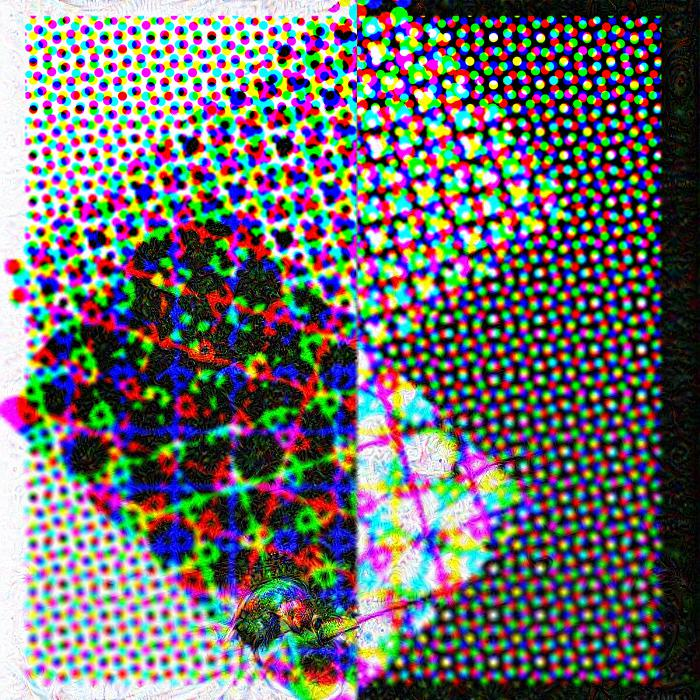

3 9 inception_5b/output (700, 700, 3)


In [17]:
# _=deepdream(net, img)


for i in layer_list:

    mode = i
    temp = deepdream(net, img, end = mode)

    date_string = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M")
    # PIL.Image.fromarray(np.uint8(temp)).save("frames/"+date_string+".jpg")

    dirname = "layers/"+mode

    try:
        os.makedirs(dirname)
        PIL.Image.fromarray(np.uint8(temp)).save("layers/"+mode+"/"+date_string+"q.jpg")

    except OSError:
        if os.path.exists(dirname):
            # We are nearly safe
            PIL.Image.fromarray(np.uint8(temp)).save("layers/"+mode+"/"+date_string+"q.jpg")
            pass
        else:
            # There was an error on creation, so make sure we know about it

            raise

   

   